In [2]:
import numpy as np
import torch 
from utils.model import *
from utils.loss import *
from utils.visualization import *
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from utils.loader import SteadyDataset

### Domain and constants initialization

In [3]:
#physical and domain parameters

#reynolds and viscosity
Re = 40 
nu = 1/Re 
lambda_ = -Re/2 + np.sqrt((Re/2)**2 + 4 *np.pi**2)

#define domain
start_x = -0.5
end_x = 1
start_y = -0.5
end_y = 1.5

In [4]:



def get_domain(dom_size):
    """
    Create a 2D grid of dom_size² points in the domain

    Args:
        dom_size (int): Number of points in each dimension

    Returns:
        torch.Tensor: (dom_size², 2) tensor with the 2D grid to feed to the model
    """
    x_dom = torch.linspace(start_x, end_x, dom_size)
    y_dom = torch.linspace(start_y, end_y, dom_size)

    X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij')  # Create a 2D grid
    X_flat = torch.stack([X.flatten(), Y.flatten()], dim=1)  # Flatten to (N, 2)
    #for the equation loss
    X_flat.requires_grad_(True)

    return X_flat



In [5]:
#boundary conditions


def boundary_conditions(n_boundary_samples):
    """
    Create boundary conditions for the problem

    Args:
        n_boundary_samples (int): Number of samples to take on each side of the domain

    Returns:
        X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top: Tensors containing the coordinates and values of the boundary conditions
    """

    x_dom_bound = torch.linspace(start_x, end_x, n_boundary_samples)
    y_dom_bound = torch.linspace(start_y, end_y, n_boundary_samples)


    #left
    X_left = torch.zeros((n_boundary_samples, 2))
    X_left[:, 0] = start_x
    X_left[:, 1] = y_dom_bound

    Y_left = torch.zeros((n_boundary_samples, 3))
    Y_left[:,0] = 1 - torch.exp(lambda_*X_left[:,0])*torch.cos(2*np.pi*X_left[:,1])
    Y_left[:,1] = (lambda_/(2*np.pi))*torch.exp(lambda_*X_left[:,0])*torch.sin(2*np.pi*X_left[:,1])
    Y_left[:,2] = 0.5*(1 - torch.exp(2*lambda_*X_left[:,0]))

    #right
    X_right = torch.zeros((n_boundary_samples, 2))
    X_right[:,0] = end_x
    X_right[:, 1] = y_dom_bound


    Y_right = torch.zeros((n_boundary_samples, 3))
    Y_right[:,0] = 1 - torch.exp(lambda_*X_right[:,0])*torch.cos(2*np.pi*X_right[:,1])
    Y_right[:,1] = (lambda_/(2*np.pi))*torch.exp(lambda_*X_right[:,0])*torch.sin(2*np.pi*X_right[:,1])
    Y_right[:,2] = 0.5*(1 - torch.exp(2*lambda_*X_right[:,0]))

    #bot
    X_bot = torch.zeros((n_boundary_samples, 2))
    X_bot[:,0] = x_dom_bound
    X_bot[:,1] = start_y

    Y_bot = torch.zeros((n_boundary_samples, 3))
    Y_bot[:,0] = 1 - torch.exp(lambda_*X_bot[:,0])*torch.cos(2*np.pi*X_bot[:,1])
    Y_bot[:,1] = (lambda_/(2*np.pi))*torch.exp(lambda_*X_bot[:,0])*torch.sin(2*np.pi*X_bot[:,1])
    Y_bot[:,2] = 0.5*(1 - torch.exp(2*lambda_*X_bot[:,0]))

    #top
    X_top = torch.zeros((n_boundary_samples, 2))
    X_top[:,0] = x_dom_bound
    X_top[:,1] = end_y

    Y_top = torch.zeros((n_boundary_samples, 3))
    Y_top[:,0] = 1 - torch.exp(lambda_*X_top[:,0])*torch.cos(2*np.pi*X_top[:,1])
    Y_top[:,1] = (lambda_/(2*np.pi))*torch.exp(lambda_*X_top[:,0])*torch.sin(2*np.pi*X_top[:,1])
    Y_top[:,2] = 0.5*(1 - torch.exp(2*lambda_*X_top[:,0]))

    return X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top


Each boundary condition is just the analytical solution evaluated on each side of the domain:


Left:
$$U(x_{min}, Y) = 1 - e^{\lambda x_{min}} \cos(2\pi Y)$$

$$V(x_{min}, Y) = \frac{\lambda}{2\pi} e^{\lambda x_{min}} \sin(2\pi Y)$$

$$P(x_{min}, Y) = \frac{1}{2}(1 - e^{2 \lambda x_{min}}) $$


Right:
$$U(x_{max}, Y) = 1 - e^{\lambda x_{max}} \cos(2\pi Y)$$

$$V(x_{max}, Y) = \frac{\lambda}{2\pi} e^{\lambda x_{max}} \sin(2\pi Y)$$

$$P(x_{max}, Y) = \frac{1}{2}(1 - e^{2 \lambda x_{max}}) $$

Bot:
$$U(X, y_{min}) = 1 - e^{\lambda X} \cos(2\pi y_{min})$$

$$V(X, y_{min}) = \frac{\lambda}{2\pi} e^{\lambda X} \sin(2\pi y_{min})$$

$$P(X, y_{min}) = \frac{1}{2}(1 - e^{2 \lambda X}) $$


Top:
$$U(X, y_{max}) = 1 - e^{\lambda X} \cos(2\pi y_{max})$$

$$V(X, y_{max}) = \frac{\lambda}{2\pi} e^{\lambda X} \sin(2\pi y_{max})$$

$$P(X, y_{max}) = \frac{1}{2}(1 - e^{2 \lambda X}) $$



### Training and hyperparameters tuning

In [6]:
#training loop
#model and optimizer

#no batching was needed to achieve conevergence
def train(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top, beta, N_EPOCH, lr=1e-3, alpha=1, verbose=False, plot=False, nu=1/40):
    """Train and return a model

    Args:
        X_flat (torch.Tensor): (N, 2) tensor with the 2D grid to feed to the model
        X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top: Tensors containing the coordinates and values of the boundary conditions
        beta (float): Weight of the boundary condition loss
        N_EPOCH (int): Number of epochs to train
        lr (float, optional): Learning rate. Defaults to 1e-3.
        alpha (int, optional): Weight of the equation loss. Defaults to 1.
        verbose (bool, optional): Print loss every 10 epochs. Defaults to False.
        plot (bool, optional): Plot the loss. Defaults to False.
    """

    model = PINNS_MLP_kovasznay(num_hidden_layers=7, hidden_layer_size=50)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses_equa = np.zeros(N_EPOCH)
    losses_boundary = np.zeros(N_EPOCH)
    for i in range(N_EPOCH):
            
        optimizer.zero_grad()
        loss_equa = model_loss_equation_kovasznay(model, X_flat, nu)
        loss_boundary = model_loss_boundary_kovasznay(model, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top)

        loss = alpha*loss_equa + beta*loss_boundary
        
        if (i+1) % 10 == 0 and verbose:
            print(f'ite {i+1}, loss equa: {loss_equa}, loss boundary: {loss_boundary}')

        loss.backward()
        optimizer.step()

        losses_equa[i] = loss_equa.item()
        losses_boundary[i] = loss_boundary.item()

    if plot:
        plt.plot(range(N_EPOCH), losses_equa, label='Equation loss')
        plt.plot(range(N_EPOCH), losses_boundary, label='Boundary condition loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(r'Loss vs epoch, $(\alpha, \beta) = $' + f'({alpha}, {int(beta)})')
        plt.legend(loc='upper right')
        plt.show()

    return losses_equa, losses_boundary, model

In [7]:
#comparison with analytical solution:
def compare_analytical_solution(model, X):
    """
    Compare the analytical solution with the model prediction

    Args:
        model (torch.nn.Module): The trained model to evaluate
        X (torch.Tensor): The input data

    Returns:
        MSE for each component of the solution
    """

    Y_pred = model(X)
    x = X[:,0]
    y = X[:,1]
    U = 1 - torch.exp(lambda_*x)*torch.cos(2*np.pi*y)
    V = (lambda_/(2*np.pi))*torch.exp(lambda_*x)*torch.sin(2*np.pi*y)
    P = 0.5*(1 - torch.exp(2*lambda_*x))

    return torch.mean((Y_pred[:,0] - U)**2), torch.mean((Y_pred[:,1] - V)**2), torch.mean((Y_pred[:,2] - P)**2)



def compare_analytical_solution_L2_relative(model, X):
    """
    Compare the analytical solution with the model prediction

    Args:
        model (torch.nn.Module): The trained model to evaluate
        X (torch.Tensor): The input data

    Returns:
        L2 relative error for each component of the solution
    """

    Y_pred = model(X)
    x = X[:,0]
    y = X[:,1]
    U = 1 - torch.exp(lambda_*x)*torch.cos(2*np.pi*y)
    V = (lambda_/(2*np.pi))*torch.exp(lambda_*x)*torch.sin(2*np.pi*y)
    P = 0.5*(1 - torch.exp(2*lambda_*x))

    return torch.norm(Y_pred[:,0] - U, 2)/torch.norm(U, 2), torch.norm(Y_pred[:,1] - V, 2)/torch.norm(V, 2), torch.norm(Y_pred[:,2] - P, 2)/torch.norm(P, 2)


In [8]:
def grid_search(domain_sizes, boundary_sizes, betas, N_EPOCH, nu=1/40):
    """
    Perform a grid search over the domain sizes, boundary sizes and betas

    Args:
        domain_sizes (list): List of domain sizes
        boundary_sizes (list): List of boundary sizes
        betas (list): List of beta values
        N_EPOCH (int): Number of epochs to train the model
        nu: viscosity

    Returns:
        mse_U, mse_V, mse_P: Arrays with the MSE for each component of the solution

    """

    size = len(domain_sizes)*len(boundary_sizes)*len(betas)
    mse_U = np.zeros(size)
    mse_V = np.zeros(size)
    mse_P = np.zeros(size)


    i = 0
    for domain_size in domain_sizes:
        X_flat = get_domain(domain_size)
        for boundary_size in boundary_sizes:
            
            X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top = boundary_conditions(boundary_size)
            for beta in betas:
                _, _, model = train(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top, beta, N_EPOCH)

                mse_U[i], mse_V[i], mse_P[i] = compare_analytical_solution(model, X_flat)
                if i % 10 == 0:
                    print(i)
                i+=1


    np.savetxt('./gridsearch/mse_u.txt', mse_U)
    np.savetxt('./gridsearch/mse_v.txt', mse_V)
    np.savetxt('./gridsearch/mse_p.txt', mse_P)

    return mse_U, mse_V, mse_P


In [9]:
def grid_search_2d(domain_sizes, boundary_sizes, beta, N_EPOCH, nu=1/40):
    """
    Perform a grid search over the domain sizes and boundary sizes

    Args:
        domain_sizes (list): List of domain sizes
        boundary_sizes (list): List of boundary sizes
        beta: beta value
        N_EPOCH (int): Number of epochs to train the model
        nu: viscosity

    Returns:
        grid_U, grid_V, grid_P: 2D Arrays with the MSE for each component of the solution
    """

    grid_U = np.zeros((len(domain_sizes), len(boundary_sizes)))
    grid_V = np.zeros((len(domain_sizes), len(boundary_sizes)))
    grid_P = np.zeros((len(domain_sizes), len(boundary_sizes)))

    ite = 0
    for i, dom_size in enumerate(domain_sizes):
        X_flat = get_domain(dom_size)
        for j, bound_size in enumerate(boundary_sizes):
            X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top = boundary_conditions(bound_size)
            _, _, model = train(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top, beta, N_EPOCH)

            grid_U[i,j], grid_V[i,j], grid_P[i,j] = compare_analytical_solution(model, X_flat)
            if ite % 10 == 0:
                print(ite)
            ite +=1

    np.savetxt('./gridsearch/mse_u_2d.txt', grid_U)
    np.savetxt('./gridsearch/mse_v_2d.txt', grid_V)
    np.savetxt('./gridsearch/mse_p_2d.txt', grid_P)

    return grid_U, grid_V, grid_P


In [ ]:
domain_sizes = [5, 10, 15, 20, 25, 30, 50, 60] #sqrt(mtilde)
boundary_sizes = [4, 9, 14, 19, 24, 29, 35, 50] #m bar/4
beta = 1e1
N_EPOCH = 600 #less epochs for grid search

grid_U, grid_V, grid_P= grid_search_2d(domain_sizes, boundary_sizes, beta, N_EPOCH)

In [ ]:
mse_tot = (grid_U + grid_V + grid_P)/3
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(mse_tot, annot=True, fmt=".2f", cmap='coolwarm')
axes.set_xticks(np.arange(len(domain_sizes)))
axes.set_xticklabels(domain_sizes, rotation=45)
axes.set_yticks(np.arange(len(boundary_sizes)))
axes.set_yticklabels(boundary_sizes)
plt.title(r'Grid search on total MSE, $\beta = 10$')
axes.set_xlabel(r'$\sqrt{\tilde{N}}$', fontsize=14)
axes.set_ylabel(r'$\frac{N_b}{4}$', fontsize=14)
plt.savefig('./plot/gridtotalmse.pdf')
plt.show()

In [ ]:
#this has been done first to find the best beta then we can do the 2d grid search for the domain and boundary sizes

domain_sizes = [60] #sqrt(mtilde)
boundary_sizes = [50] #m bar/4
betas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
N_EPOCH = 600 #less epochs for grid search

mse_U, mse_V, mse_P = grid_search(domain_sizes, boundary_sizes, betas, N_EPOCH)


In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(6, 18))

# Plot MSE on U
axes[0].plot(betas, mse_U)
axes[0].set_xscale('log')
axes[0].grid(axis='both', linestyle='--')
axes[0].set_xlabel(r'$\beta$', fontsize=14)
axes[0].set_ylabel(r'MSE on $v_x$', fontsize=14)
axes[0].set_title(r'MSE on $v_x$ vs beta', fontsize=16)

# Plot MSE on V
axes[1].plot(betas, mse_V)
axes[1].set_xscale('log')
axes[1].grid(axis='both', linestyle='--')
axes[1].set_xlabel(r'$\beta$', fontsize=14)
axes[1].set_ylabel(r'MSE on $v_y$', fontsize=14)
axes[1].set_title(r'MSE on $v_y$ vs beta', fontsize=16)

# Plot MSE on P
axes[2].plot(betas, mse_P)
axes[2].set_xscale('log')
axes[2].grid(axis='both', linestyle='--')
axes[2].set_xlabel(r'$\beta$', fontsize=14)
axes[2].set_ylabel(r'MSE on $p$', fontsize=14)
axes[2].set_title(r'MSE on $p$ vs beta', fontsize=16)

plt.tight_layout()
plt.savefig('./plot/search_beta_vert.pdf')
plt.show()

In [ ]:

#to complete and retrain with best parameters

dom_size_star = 60
boundary_size_star = 50
beta_star = 1e1

x_dom = torch.linspace(start_x, end_x, dom_size_star)
y_dom = torch.linspace(start_y, end_y, dom_size_star)
X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij') 
X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top = boundary_conditions(boundary_size_star)
X_flat = get_domain(dom_size_star) #to complete


_, _, model_star = train(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top, beta_star, 1000, verbose=True, plot=True) #to complete

Y_hat = model_star(X_flat)

U_hat = Y_hat[:,0]
V_hat = Y_hat[:,1]
P_hat = Y_hat[:,2]

visualize_sol(X, Y, U_hat.detach().numpy().reshape(X.shape), V_hat.detach().numpy().reshape(X.shape), P_hat.detach().numpy().reshape(X.shape), 'kov_pinns')


#true solution
U = 1 - torch.exp(lambda_*X)*torch.cos(2*np.pi*Y)
V = (lambda_/(2*np.pi))*torch.exp(lambda_*X)*torch.sin(2*np.pi*Y)
P = 0.5*(1 - torch.exp(2*lambda_*X))
visualize_sol(X, Y, U, V, P, 'kov_analytical')



### Dynamical Weights

In [43]:
dom_size_star = 60
boundary_size_star = 50

X_flat = get_domain(dom_size_star)
X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top = boundary_conditions(boundary_size_star)


dataset = SteadyDataset(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top)

norm
ite 0, equa loss: 0.0015633904971699458, boundary loss: 8.725422314235143, alpha:46.888771057128906, beta: 1.696431040763855
ite 10, equa loss: 0.3639484941959381, boundary loss: 7.2451051984514505, alpha:0.43330928683280945, beta: 0.09323583543300629
ite 20, equa loss: 0.30359905532428194, boundary loss: 7.14189338684082, alpha:0.35038214921951294, beta: 0.07011701911687851
ite 30, equa loss: 0.2042450053351266, boundary loss: 7.101687363215855, alpha:0.321765273809433, beta: 0.05414825677871704
ite 40, equa loss: 0.1478163344519479, boundary loss: 7.060854026249477, alpha:0.2792966961860657, beta: 0.04291651025414467
ite 50, equa loss: 0.1069052591919899, boundary loss: 7.013471807752337, alpha:0.25935864448547363, beta: 0.03471783176064491
ite 60, equa loss: 0.07186202598469597, boundary loss: 6.972938741956439, alpha:0.2580648958683014, beta: 0.028599116951227188
ite 70, equa loss: 0.0579560250043869, boundary loss: 6.9323128291538785, alpha:0.22561165690422058, beta: 0.023824

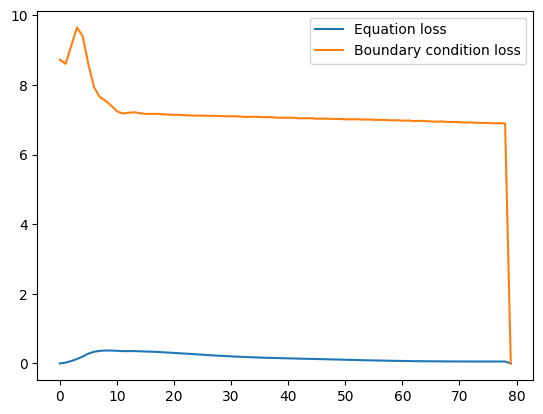

MSE on U: 0.786074697971344, MSE on V: 1.0004909038543701, MSE on P: 0.8873144388198853


c:\Users\matya\OneDrive - epfl.ch\M1\Fall\MachineLearning\ml-project-2-uclearning-pinns\utils\visualization.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


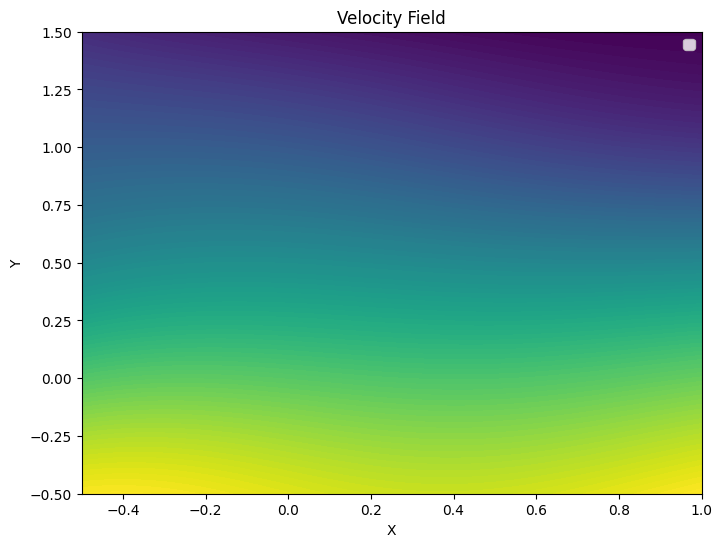

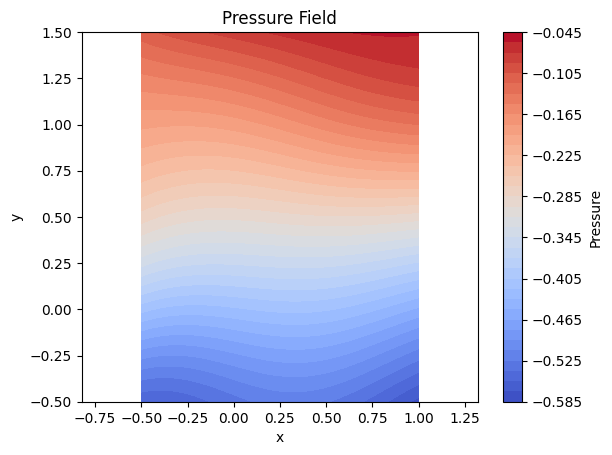

mean
ite 0, equa loss: 0.0004883393594354857, boundary loss: 7.66063506262643, alpha:1, beta: 0.0031540775671601295
ite 10, equa loss: 6.144708088466099, boundary loss: 2.215134995324271, alpha:1, beta: 2.442464828491211
ite 20, equa loss: 3.890490770339966, boundary loss: 1.959063240459987, alpha:1, beta: 2.893660545349121
ite 30, equa loss: 2.003591077668326, boundary loss: 2.0926304204123363, alpha:1, beta: 4.144176959991455
ite 40, equa loss: 1.3971854788916451, boundary loss: 2.1665535994938443, alpha:1, beta: 4.563168525695801
ite 50, equa loss: 1.2635189124516077, boundary loss: 2.184697049004691, alpha:1, beta: 3.920269727706909
ite 60, equa loss: 1.282609019960676, boundary loss: 2.1769230365753174, alpha:1, beta: 3.9023358821868896
ite 70, equa loss: 1.1964650665010725, boundary loss: 2.192049707685198, alpha:1, beta: 6.017016887664795


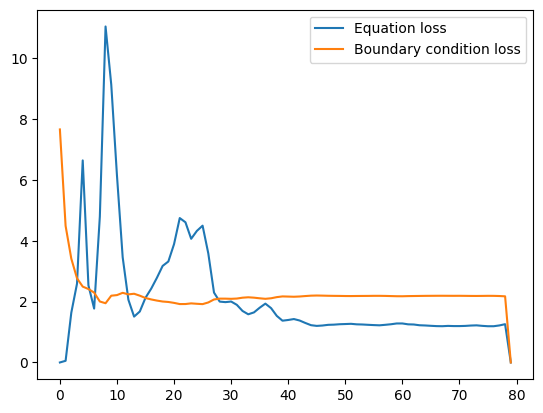

MSE on U: 0.9064448475837708, MSE on V: 1.0003337860107422, MSE on P: 0.33626142144203186


c:\Users\matya\OneDrive - epfl.ch\M1\Fall\MachineLearning\ml-project-2-uclearning-pinns\utils\visualization.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


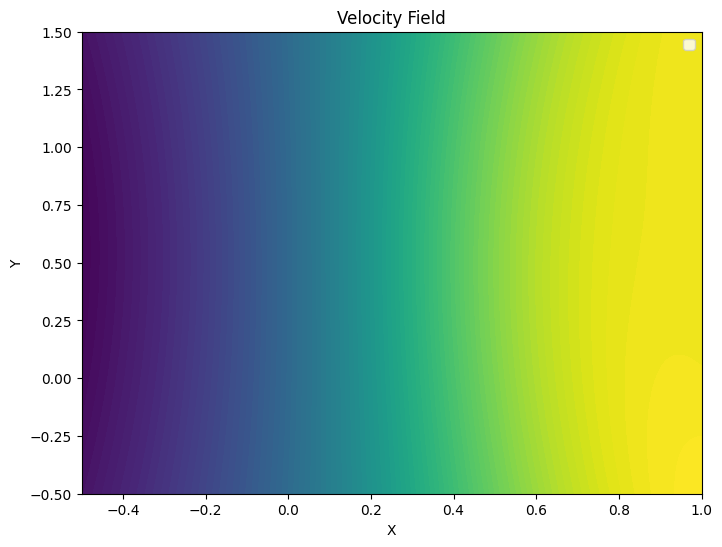

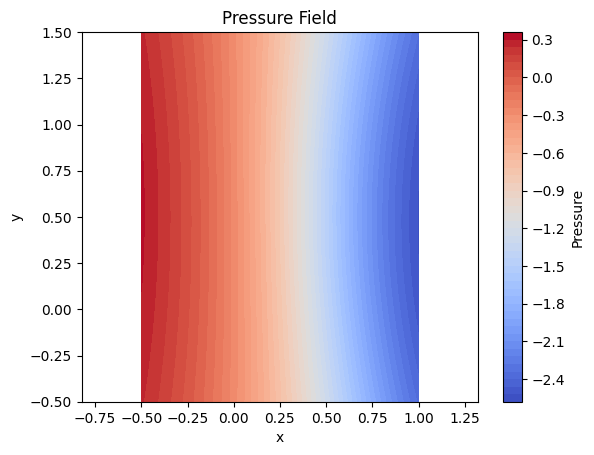

mean_alternative
ite 0, equa loss: 3.2613910418279245e-05, boundary loss: 9.487244878496442, alpha:1, beta: 0.00013934052549302578
ite 10, equa loss: 4.03973754448117e-09, boundary loss: 8.861199515206474, alpha:1, beta: 1.982931644306518e-05


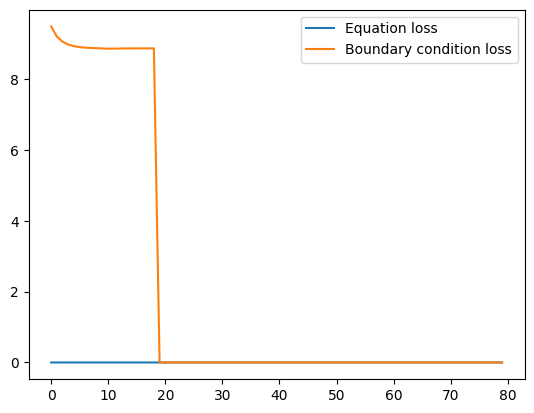

MSE on U: 0.940915048122406, MSE on V: 0.9999969005584717, MSE on P: 0.956518292427063


c:\Users\matya\OneDrive - epfl.ch\M1\Fall\MachineLearning\ml-project-2-uclearning-pinns\utils\visualization.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


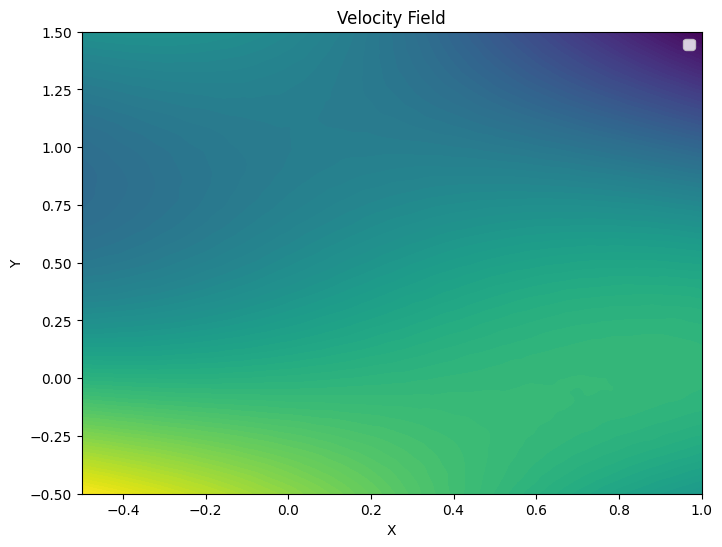

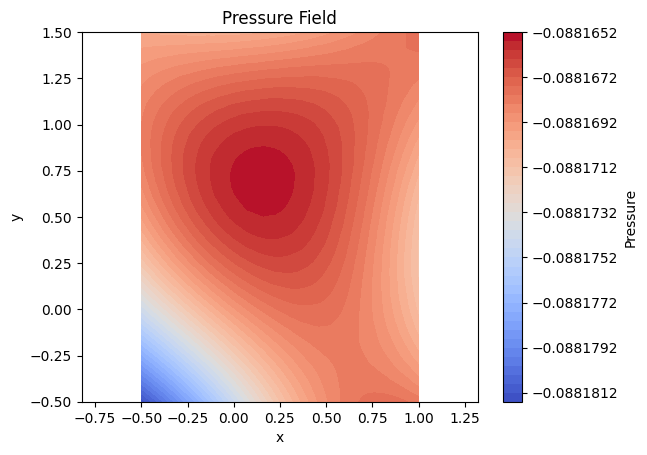

constant
ite 0, equa loss: 0.00160908018823339, boundary loss: 7.533348628452846, alpha:1, beta: 10
ite 10, equa loss: 1.8710149696895055, boundary loss: 2.1019937651497975, alpha:1, beta: 10
ite 20, equa loss: 4.184452533721924, boundary loss: 1.603523918560573, alpha:1, beta: 10
ite 30, equa loss: 3.5519567898341586, boundary loss: 1.0597311769212996, alpha:1, beta: 10
ite 40, equa loss: 4.408931050981794, boundary loss: 0.5043818354606628, alpha:1, beta: 10
ite 50, equa loss: 3.4848944459642683, boundary loss: 0.1396531260439328, alpha:1, beta: 10
ite 60, equa loss: 1.7665986333574568, boundary loss: 0.0946487688592502, alpha:1, beta: 10
ite 70, equa loss: 1.146666169166565, boundary loss: 0.07632858519043241, alpha:1, beta: 10


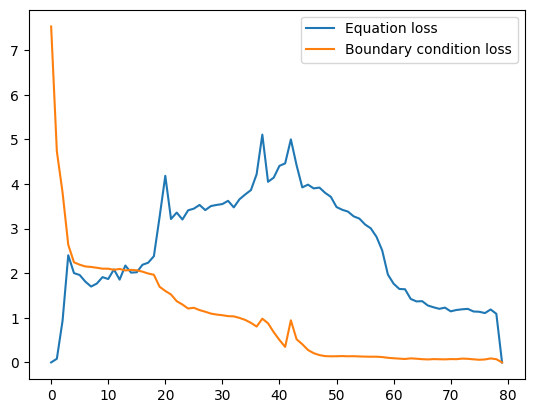

MSE on U: 0.14731667935848236, MSE on V: 0.33455660939216614, MSE on P: 0.10768426209688187


c:\Users\matya\OneDrive - epfl.ch\M1\Fall\MachineLearning\ml-project-2-uclearning-pinns\utils\visualization.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


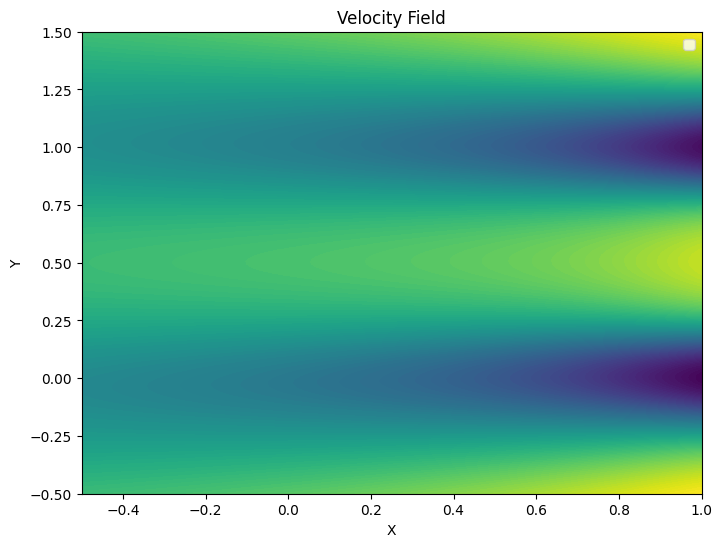

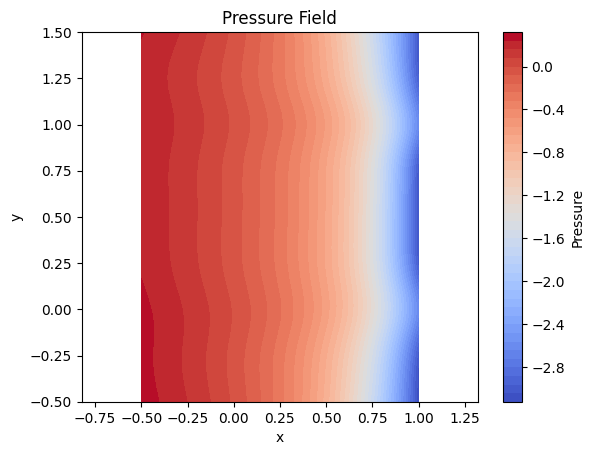

In [44]:


def train_dynamic(N_EPOCH, type, alpha_val, beta_val, model, optimizer, order=2, eps=1e-12):
    """
    Train the model with dynamic weights

    Args:
        N_EPOCH (int): Number of epochs to train the model
        type (str): Type of dynamic weights to use
        alpha_val (float): Value of alpha if needed
        beta_val (float): Value of beta if needed
        model (torch.nn.Module): The model to train
        optimizer (torch.optim): The optimizer to use
        order (int): Order of the norm to use
        eps (float): Small value to avoid division by zero

    Returns:
        equa_loss, boundary_loss, model: Arrays with the losses and the trained model
    
    """


    batch_size = 4*boundary_size_star #same number as points on boundary
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    equa_loss = np.zeros(N_EPOCH)
    boundary_loss = np.zeros(N_EPOCH)

    #for mean method
    beta = beta_val

    has_converged = False



    i = 0
    while not has_converged:
        if i == N_EPOCH - 1:
            break
        total_equa_loss = 0
        total_boundary_loss = 0
        for j, X_batch in enumerate(dataloader):


            optimizer.zero_grad()
            loss_equa = model_loss_equation_kovasznay(model, X_batch, nu)
            loss_boundary = model_loss_boundary_kovasznay(model, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top)

            total_equa_loss += loss_equa.item()
            total_boundary_loss += loss_boundary.item()

            equa_grad = torch.autograd.grad(loss_equa, model.parameters(), create_graph=True, allow_unused=True)[0]
            boundary_grad = torch.autograd.grad(loss_boundary, model.parameters(), create_graph=True, allow_unused=True)[0]

            norm_grad_pde = torch.norm(equa_grad, order) 
            norm_grad_boundary = torch.norm(boundary_grad, order)

            if type == 'constant':
                alpha = alpha_val
                beta = beta_val

            if type == 'ratio':
                alpha = 1
                beta = norm_grad_boundary/(norm_grad_pde + eps)
                beta = max(beta, 100)

            if type == 'norm':
                alpha = 1/(norm_grad_pde + eps)
                beta = 1/(norm_grad_boundary + eps)

            if type == 'mean': #method from paper
                alpha = 1
                beta = torch.max(torch.abs(equa_grad))/(beta*torch.mean(torch.abs(boundary_grad)) + eps)
                beta = beta.item()

            if type == 'mean_alternative': #other method from paper
                alpha = 1
                beta = torch.mean(torch.abs(equa_grad))/torch.mean(torch.abs(boundary_grad) + eps)



            loss = alpha*loss_equa + beta*loss_boundary
            loss.backward()
            optimizer.step()

        #mean on batches
        equa_loss[i] = total_equa_loss/len(dataloader)
        boundary_loss[i] = total_boundary_loss/len(dataloader)

        if i > 10:
            tol = 5*1e-3
            #convergence criterion based on std of loss
            has_converged = (np.std(equa_loss[i-10:i]) < tol) and (np.std( boundary_loss[i-10:i]) < tol)

        if i % 10 == 0:
            print(f'ite {i}, equa loss: {equa_loss[i]}, boundary loss: {boundary_loss[i]}, alpha:{alpha}, beta: {beta}')
        i +=1


    return equa_loss, boundary_loss, model


N_EPOCH = 80
alpha = 1
beta = 10


types = ['norm', 'mean', 'mean_alternative', 'constant']


for type in types:

    print(type)
    #change to PINNS_MLP_ethz(hidden_dim = 128, L = 10) and the filename or just load the train models
    model = PINNS_MLP_kovasznay(num_hidden_layers=10, hidden_layer_size=128)
    equa_loss, boundary_loss, model = train_dynamic(N_EPOCH, type, 1, 10, model, torch.optim.Adam(model.parameters(), lr=1e-3))
    torch.save(model.state_dict(), f'./saved_models/model_{type}_MLP.pth')
    np.savetxt(f'./type_txt/loss_equa_{type}.txt', equa_loss)
    np.savetxt(f'./type_txt/loss_boundary_{type}.txt', boundary_loss)

    #note that in case of convergence the loss will be 0 for the last values
    plt.plot(range(N_EPOCH), equa_loss, label='Equation loss')
    plt.plot(range(N_EPOCH), boundary_loss, label='Boundary condition loss')
    plt.legend(loc='upper right')
    plt.savefig(f'./plot/loss_{type}_MLP.pdf')
    plt.show()


    x_dom = torch.linspace(start_x, end_x, 60)
    y_dom = torch.linspace(start_y, end_y, 60)
    X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij') 
    X_flat = get_domain(51)

    Y_hat = model(X_flat)

    U_hat = Y_hat[:,0]
    V_hat = Y_hat[:,1]
    P_hat = Y_hat[:,2]

    e_u, e_v, e_p = compare_analytical_solution_L2_relative(model, X_flat)

    mse = np.array([e_u.item(), e_v.item(), e_p.item()])

    np.savetxt(f'./type_txt/mse_{type}_MLP.txt',mse)

    print(f'Relative error on U: {e_u}, Relative error on V: {e_v}, Relative error on P: {e_p}')

    vis_velocity(X_flat.detach().numpy(), U_hat.detach().numpy(), f'velocity_{type}_MLP', grid_res=200, method='cubic')
    vis_pressure(X.detach().numpy(), Y.detach().numpy(), P_hat.detach().numpy().reshape(X.shape), f'pressure_{type}_MLP')


    



In [46]:
#results in table I of the report

types = ['norm', 'mean', 'mean_alternative', 'constant']

print('eth model')
for type in types:
    model = PINNS_MLP_ethz(hidden_dim = 128, L = 10)
    print(type)
    model.load_state_dict(torch.load(f'./saved_models/model_{type}.pth'))
    x_dom = torch.linspace(start_x, end_x, 100)
    y_dom = torch.linspace(start_y, end_y, 100)
    X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij') 
    X_flat = get_domain(100)

    Y_hat = model(X_flat)

    U_hat = Y_hat[:,0]
    V_hat = Y_hat[:,1]
    P_hat = Y_hat[:,2]

    e_u, e_v, e_p = compare_analytical_solution_L2_relative(model, X_flat)

    mse = np.array([e_u.item(), e_v.item(), e_p.item()])
    print(mse)



print('MLP model')
for type in types:
    model = PINNS_MLP_kovasznay(num_hidden_layers=10, hidden_layer_size=128)
    print(type)
    model.load_state_dict(torch.load(f'./saved_models/model_{type}_MLP.pth'))
    x_dom = torch.linspace(start_x, end_x, 100)
    y_dom = torch.linspace(start_y, end_y, 100)
    X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij') 
    X_flat = get_domain(100)

    Y_hat = model(X_flat)

    U_hat = Y_hat[:,0]
    V_hat = Y_hat[:,1]
    P_hat = Y_hat[:,2]

    e_u, e_v, e_p = compare_analytical_solution_L2_relative(model, X_flat)

    mse = np.array([e_u.item(), e_v.item(), e_p.item()])
    print(mse)


eth
norm
[0.98509318 2.03283763 0.45299187]
mean
[0.18703124 0.50400138 0.27704832]
mean_alternative
[0.8455016  1.40076542 0.89741313]
constant
[0.32860082 0.94496804 0.46805081]
MLP
norm
[0.78562045 1.00036156 0.88592577]
mean
[0.91725928 1.00034273 0.34127563]
mean_alternative
[0.94052714 0.9999972  0.95585233]
constant
[0.14912857 0.33303756 0.10954173]


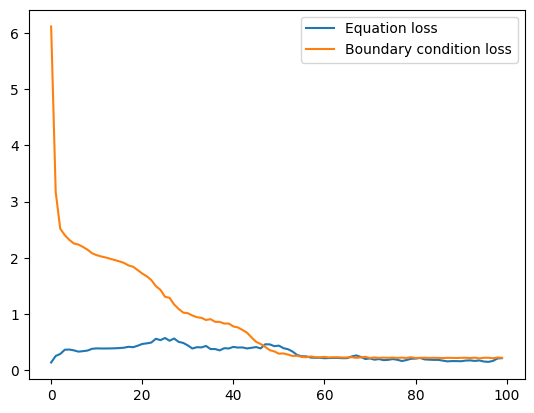

In [11]:
plt.plot(range(N_EPOCH), equa_loss, label='Equation loss')
plt.plot(range(N_EPOCH), boundary_loss, label='Boundary condition loss')
plt.legend(loc='upper right')

In [ ]:
dom_size_star = 60
boundary_size_star = 50
alpha = 1
beta = 10
eps = 1e-12

X_flat = get_domain(dom_size_star)
X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top = boundary_conditions(boundary_size_star)

dataset = SteadyDataset(X_flat, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top)
dataloader = DataLoader(dataset, batch_size=4*boundary_size_star, shuffle=True)
x_dom = torch.linspace(start_x, end_x, 60)
y_dom = torch.linspace(start_y, end_y, 60)
X, Y = torch.meshgrid(x_dom, y_dom, indexing='ij') 

model = PINNS_MLP_kovasznay(num_hidden_layers=10, hidden_layer_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

order = 2

for i in range(150):

    for X_batch in dataloader:
        
        optimizer.zero_grad()


        loss_equa = model_loss_equation_kovasznay(model, X_batch, nu)
        loss_boundary = model_loss_boundary_kovasznay(model, X_left, X_right, X_bot, X_top, Y_left, Y_right, Y_bot, Y_top)


        equa_grad = torch.autograd.grad(loss_equa, model.parameters(), create_graph=True, allow_unused=True)[0]
        boundary_grad = torch.autograd.grad(loss_boundary, model.parameters(), create_graph=True, allow_unused=True)[0]

        norm_grad_pde = torch.norm(equa_grad, order) 
        norm_grad_boundary = torch.norm(boundary_grad, order)

        alpha = 1
        beta = torch.max(torch.abs(equa_grad))/(beta*torch.mean(torch.abs(boundary_grad)) + eps)
        beta = beta.item()

        loss = alpha*loss_equa + beta*loss_boundary
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f'ite {i}, equa loss: {loss_equa}, boundary loss: {loss_boundary}, alpha:{alpha}, beta: {beta}')
    


U_hat = Y_hat[:,0]
V_hat = Y_hat[:,1]
P_hat = Y_hat[:,2]

e_u, e_v, e_p = compare_analytical_solution_L2_relative(model, X_flat)

mse = np.array([e_u.item(), e_v.item(), e_p.item()])


print(f'Relative error on U: {e_u}, Relative error on V: {e_v}, Relative error on P: {e_p}')

vis_velocity(X_flat.detach().numpy(), U_hat.detach().numpy(), f'mlp_final_velocity', grid_res=200, method='cubic')
vis_pressure(X.detach().numpy(), Y.detach().numpy(), P_hat.detach().numpy().reshape(X.shape), f'mlp_final_velocity')


ite 0, equa loss: 0.0002816194319166243, boundary loss: 9.100676536560059, alpha:1, beta: 0.012867649085819721
ite 10, equa loss: 7.7371110916137695, boundary loss: 1.8964734077453613, alpha:1, beta: 1.1174598932266235
ite 20, equa loss: 2.0271525382995605, boundary loss: 2.1371443271636963, alpha:1, beta: 4.286535739898682
ite 30, equa loss: 1.6115663051605225, boundary loss: 2.1413636207580566, alpha:1, beta: 3.918569564819336
ite 40, equa loss: 1.5858548879623413, boundary loss: 2.153528928756714, alpha:1, beta: 5.310914516448975
ite 50, equa loss: 1.596785306930542, boundary loss: 2.134753465652466, alpha:1, beta: 4.097590923309326
ite 60, equa loss: 1.5621782541275024, boundary loss: 2.1343767642974854, alpha:1, beta: 4.343367576599121
ite 70, equa loss: 1.4051169157028198, boundary loss: 2.163464069366455, alpha:1, beta: 4.880586624145508
ite 80, equa loss: 1.422171950340271, boundary loss: 2.170849323272705, alpha:1, beta: 7.105559825897217
ite 90, equa loss: 1.2804492712020874,